### Generate some statistics files

In [1]:
! pip install libsumo addict

In [1]:
import analysis.stats_utils_v2 as stats_utils
from analysis.viz_utils_v2 import visualizer
import os
from tqdm import tqdm
# change here
exp_repo = "/media/mtl/2TB/AWS_result"
mode="cosim_test_localcomputer7"
user = "haowei"
experiment_record_repo = f"{exp_repo}/{mode}/raw_data"
export_stat_dir = f"{exp_repo}/{mode}/{user}/processed_data"

# # test code
# experiment_record_repo = "output/test/raw_data"
# export_stat_dir = "output/test/processed_data"
# export_stat_dir = "."

if not os.path.exists(export_stat_dir):
    os.system(f"mkdir -p {export_stat_dir}")
    os.system(f"chmod 755 {export_stat_dir}")

In [2]:
stats_utils.export_to_csv(experiment_record_repo, export_stat_dir)
os.system(f"chmod -R 775 {export_stat_dir}")

0it [00:00, ?it/s]
0it [00:00, ?it/s]

info_error:  0


0

In [4]:
awk_cmd = """awk -F "[_/]" '{print $35}'""" + " check.txt | sort | uniq -cd"
print("count", "exp_id")
os.system(awk_cmd)

count exp_id


0

### Analyze

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

/tmp/ipykernel_1000279/2290088659.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


#### Import statistics of each experiment

In [6]:
exp_stats_info = pd.read_csv(f"{export_stat_dir}/stats.tsv", sep='\t')
exp_stats_info.head()

,name,end_time,crash_veh_1,crash_veh_2,importance,maneuver_challenge,neg_veh,neg_time_diff,neg_reason,neg_info,route_length,bv_22_route_length,lane_id,collision_type,location_type,relative_heading,distance
0,cosim_test_localcomputer7_0_1,1137.1,CAV,BV_12.11,6.252246,1,BV_12.11,3.1,Lead,intersection_neglect_conflict_lead,48035.531115,1032.919326,:NODE_17_1_0,angle,intersection,100.516761,3.280000
1,cosim_test_localcomputer7_0_2,1357.9,NaN,NaN,-0.228786,5,NaN,-1.0,NaN,NaN,78744.947529,5900.028687,NaN,NaN,NaN,NaN,-10.000000
2,cosim_test_localcomputer7_0_3,1058.2,CAV,BV_14.10,10.104945,9,BV_14.10,1.5,Lead,roundabout_neglect_conflict_lead,33690.383682,2299.468542,:nd_15_1_2_0_0,sideswipe,roundabout,11.273857,0.134092
3,cosim_test_localcomputer7_0_4,1241.6,NaN,NaN,-0.183029,4,NaN,-1.0,NaN,NaN,70380.516888,3906.857286,NaN,NaN,NaN,NaN,-10.000000
4,cosim_test_localcomputer7_0_5,1312.5,NaN,NaN,-0.091515,2,NaN,-1.0,NaN,NaN,78843.004866,4437.000672,NaN,NaN,NaN,NaN,-10.000000


In [7]:
# exp_stats_info_old = pd.read_csv(f"{export_stat_dir}/stats-old.tsv", sep='\t')
# b = exp_stats_info_old[~exp_stats_info_old["neg_reason"].isna()]

# cnt = 0
# for name in a["name"]:
#     location = a[a["name"] == name]["location_type"].values[0]
#     collision_a = a[a["name"] == name]["collision_type"].values[0]
#     collision_b = b[b["name"] == name]["collision_type"].values[0]
#     if collision_a != collision_b and location == "intersection":
#         print(name, collision_a, collision_b)
#         cnt += 1
    
# print(cnt)

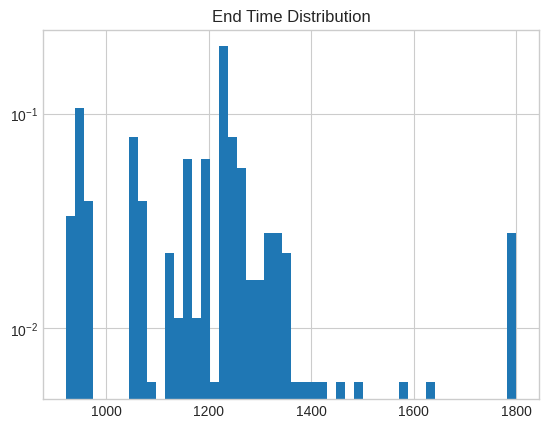

In [8]:
# draw the end time distribution
# exp_stats_info["end_time"].hist(bins=100)
num_experiments = len(exp_stats_info)
plt.hist(exp_stats_info["end_time"], weights=np.ones(num_experiments)/num_experiments, bins=50)
plt.yscale("log")
plt.title("End Time Distribution")
plt.savefig(f"{export_stat_dir}/end_time.png")

**Filter the experiments with time difference between negligence and collision larger than 3s**

In [9]:
warm_up_time = 900
estimated_end_time = warm_up_time + 300

has_collision = (exp_stats_info['end_time'] < estimated_end_time) & (exp_stats_info['end_time'] >= warm_up_time)
collision_df = exp_stats_info[has_collision]

has_collision_in_warmup = (exp_stats_info['end_time'] <= warm_up_time)
warmup_collision_df = exp_stats_info[has_collision_in_warmup]

print("Collision numbers:", len(collision_df), "Warmup collisions:", len(warmup_collision_df)) # the number of collisions 

Collision numbers: 84 Warmup collisions: 0


**See the list of files with time difference between negligence and collision larger than 3s**

### See the collisions

In [10]:
collision_df.head()

,name,end_time,crash_veh_1,crash_veh_2,importance,maneuver_challenge,neg_veh,neg_time_diff,neg_reason,neg_info,route_length,bv_22_route_length,lane_id,collision_type,location_type,relative_heading,distance
0,cosim_test_localcomputer7_0_1,1137.1,CAV,BV_12.11,6.252246,1,BV_12.11,3.1,Lead,intersection_neglect_conflict_lead,48035.531115,1032.919326,:NODE_17_1_0,angle,intersection,100.516761,3.280000
2,cosim_test_localcomputer7_0_3,1058.2,CAV,BV_14.10,10.104945,9,BV_14.10,1.5,Lead,roundabout_neglect_conflict_lead,33690.383682,2299.468542,:nd_15_1_2_0_0,sideswipe,roundabout,11.273857,0.134092
6,cosim_test_localcomputer7_0_7,1055.9,CAV,BV_14.6,5.166853,2,BV_14.6,2.2,Lead,roundabout_neglect_conflict_lead,26873.668987,873.663956,:nd_15_1_2_0_0,rear_end,roundabout,6.061871,0.172836
8,cosim_test_localcomputer7_0_9,958.0,CAV,BV_22.15,6.031771,11,BV_22.15,0.8,Lead,highway_rearend,10637.225397,964.819844,EG_1_3_1_0,rear_end,freeway_1,0.051307,-0.473801
10,cosim_test_localcomputer7_0_11,1154.6,CAV,BV_22.11,4.899864,9,BV_22.11,2.5,Lead,intersection_rearend,50213.896838,2823.834707,EG_14_2_1_0,rear_end,intersection,0.832660,-0.417694


In [11]:
all_maneuvers = exp_stats_info["maneuver_challenge"].sum()
all_time = (exp_stats_info["end_time"] - 900).sum()
all_routes = exp_stats_info["route_length"].sum()
mile_to_m = 1609.344
no_negligence_collision_related = collision_df['neg_time_diff'] < 0
power_importance_weight = np.power(10, - exp_stats_info['importance'])
collide_importance_weight = power_importance_weight[(power_importance_weight < 1) & has_collision]
importance_all = collide_importance_weight.sum()
num_experiments = len(exp_stats_info)
num_collisions = len(collision_df)
no_related_negligence_collision = collision_df[no_negligence_collision_related]

print(f"Number of experiments: {num_experiments}")
print(f"Number of collision: {num_collisions}")
print(f"Collisions with weight less than 1: {len(collide_importance_weight)}")
print(f"Importance summation: {importance_all}")
print(f"Max weight: {collide_importance_weight.max()}, Min weight: {collide_importance_weight.min()}")
print(f"raw collision rate: {num_collisions / num_experiments}")
print(f"adjusted collision rate (importance): {importance_all/num_experiments}")
print(f"Collision due to traffic light ignorance: {len(collision_df[collision_df['neg_reason'] == 'TFL'])}")
print(f"Overall maneuvers: {all_maneuvers}")

print(f"Collision without negligence: {len(no_related_negligence_collision)}")
print(f"Maximum time between collision and negligence: {collision_df['neg_time_diff'].max():.2f} s")

print()
print(f"Overall time: {all_time:.2f} s")
print(f"Maneuvers per second: {all_maneuvers / all_time}")
print(f"Overall route length: {all_routes:.2f} m")
print(f"m/s: {all_routes/all_time}")
print(f"Overall route length: {all_routes/mile_to_m} mile")
print(f"mile/s: {all_routes/mile_to_m/all_time} mile/s")
print(f"Crash per mile: {importance_all/all_routes*mile_to_m} crash/mile")

Number of experiments: 179
Number of collision: 84
Collisions with weight less than 1: 78
Importance summation: 0.010021299641250845
Max weight: 0.0019114747901373733, Min weight: 8.031175544585844e-17
raw collision rate: 0.4692737430167598
adjusted collision rate (importance): 5.5984914196932096e-05
Collision due to traffic light ignorance: 0
Overall maneuvers: 1119
Collision without negligence: 6
Maximum time between collision and negligence: 3.10 s

Overall time: 51296.90 s
Maneuvers per second: 0.021814183703108767
Overall route length: 9913433.45 m
m/s: 193.25599509876258
Overall route length: 6159.921965087459 mile
mile/s: 0.12008370808153046 mile/s
Crash per mile: 1.6268549663532241e-06 crash/mile


In [12]:
exp_stats_info.head()

,name,end_time,crash_veh_1,crash_veh_2,importance,maneuver_challenge,neg_veh,neg_time_diff,neg_reason,neg_info,route_length,bv_22_route_length,lane_id,collision_type,location_type,relative_heading,distance
0,cosim_test_localcomputer7_0_1,1137.1,CAV,BV_12.11,6.252246,1,BV_12.11,3.1,Lead,intersection_neglect_conflict_lead,48035.531115,1032.919326,:NODE_17_1_0,angle,intersection,100.516761,3.280000
1,cosim_test_localcomputer7_0_2,1357.9,NaN,NaN,-0.228786,5,NaN,-1.0,NaN,NaN,78744.947529,5900.028687,NaN,NaN,NaN,NaN,-10.000000
2,cosim_test_localcomputer7_0_3,1058.2,CAV,BV_14.10,10.104945,9,BV_14.10,1.5,Lead,roundabout_neglect_conflict_lead,33690.383682,2299.468542,:nd_15_1_2_0_0,sideswipe,roundabout,11.273857,0.134092
3,cosim_test_localcomputer7_0_4,1241.6,NaN,NaN,-0.183029,4,NaN,-1.0,NaN,NaN,70380.516888,3906.857286,NaN,NaN,NaN,NaN,-10.000000
4,cosim_test_localcomputer7_0_5,1312.5,NaN,NaN,-0.091515,2,NaN,-1.0,NaN,NaN,78843.004866,4437.000672,NaN,NaN,NaN,NaN,-10.000000


In [13]:
a = exp_stats_info[(exp_stats_info["importance"] <= 0) & (exp_stats_info["end_time"] < 1200)]
a

,name,end_time,crash_veh_1,crash_veh_2,importance,maneuver_challenge,neg_veh,neg_time_diff,neg_reason,neg_info,route_length,bv_22_route_length,lane_id,collision_type,location_type,relative_heading,distance
51,cosim_test_localcomputer7_0_52,1184.5,BV_20.34,CAV,-0.137246,3,CAV,-1.0,NaN,NaN,57658.142865,2086.945612,:NODE_22_3_0,angle,roundabout_3,59.272241,2.5
72,cosim_test_localcomputer7_0_73,1184.6,BV_16.16,CAV,-0.183029,4,CAV,-1.0,NaN,NaN,60338.504485,1681.552209,:NODE_22_2_0,angle,roundabout_3,65.994477,2.5
82,cosim_test_localcomputer7_0_83,1183.7,BV_20.43,CAV,-0.183029,4,CAV,-1.0,NaN,NaN,58580.297304,2599.335011,:NODE_22_3_0,angle,roundabout_3,64.275597,2.5
106,cosim_test_localcomputer7_0_107,1185.1,BV_23.27,CAV,-0.045757,1,CAV,-1.0,NaN,NaN,59392.904869,4760.460591,:NODE_22_3_0,angle,roundabout_3,65.334641,2.5
136,cosim_test_localcomputer7_0_137,1186.1,BV_23.33,CAV,-0.045731,1,CAV,-1.0,NaN,NaN,58502.454127,2241.386171,:NODE_22_3_0,angle,roundabout_3,65.054241,2.5
170,cosim_test_localcomputer7_0_171,1193.0,BV_20.39,CAV,-0.274492,6,CAV,-1.0,NaN,NaN,55156.810598,3776.525592,:NODE_22_3_0,angle,roundabout_3,64.378601,2.5


#### BV_22 Collision

In [14]:
is_veh_1_bv_22 = np.array(list(map(lambda x: x.startswith("BV_22"), collision_df["crash_veh_1"])))
is_veh_2_bv_22 = np.array(list(map(lambda x: x.startswith("BV_22"), collision_df["crash_veh_2"])))
has_bv_22 = is_veh_1_bv_22 | is_veh_2_bv_22
bv_22_collision_df = collision_df[has_bv_22]

total_bv_22_distance = exp_stats_info["bv_22_route_length"].sum()

num_bv_22_expr = np.sum(has_bv_22)
bv_22_collision_is_large_1 = bv_22_collision_df["importance"] < 0
power_bv_22_weight = np.power(10, -bv_22_collision_df["importance"])[~bv_22_collision_is_large_1]
bv_22_importance = np.sum(power_bv_22_weight)

print("Number of bv_22 collision:", num_bv_22_expr)
print("Total bv_22 distance:", total_bv_22_distance)
print("Number of bv_22 collision importance > 1:", np.sum(bv_22_collision_is_large_1))
print("Raw collision rate:", num_bv_22_expr / num_experiments)
print("Collision rate:", bv_22_importance / num_experiments)
print("Collision rate (weighted):", bv_22_importance / total_bv_22_distance * mile_to_m)

Number of bv_22 collision: 29
Total bv_22 distance: 480045.31463574176
Number of bv_22 collision importance > 1: 0
Raw collision rate: 0.16201117318435754
Collision rate: 1.0669255448048992e-06
Collision rate (weighted): 6.402562023240855e-07


### Crash Distribution (with negligence)

In [15]:
exp_stats_info[(exp_stats_info["importance"] <= 0) & (exp_stats_info["end_time"] < 1200) & (exp_stats_info["neg_time_diff"]  > 0)]

,name,end_time,crash_veh_1,crash_veh_2,importance,maneuver_challenge,neg_veh,neg_time_diff,neg_reason,neg_info,route_length,bv_22_route_length,lane_id,collision_type,location_type,relative_heading,distance


### Load file that show the relationship between lane and experiment

**See the collision number in each experiment**

In [16]:
exp_stats_info.head()

,name,end_time,crash_veh_1,crash_veh_2,importance,maneuver_challenge,neg_veh,neg_time_diff,neg_reason,neg_info,route_length,bv_22_route_length,lane_id,collision_type,location_type,relative_heading,distance
0,cosim_test_localcomputer7_0_1,1137.1,CAV,BV_12.11,6.252246,1,BV_12.11,3.1,Lead,intersection_neglect_conflict_lead,48035.531115,1032.919326,:NODE_17_1_0,angle,intersection,100.516761,3.280000
1,cosim_test_localcomputer7_0_2,1357.9,NaN,NaN,-0.228786,5,NaN,-1.0,NaN,NaN,78744.947529,5900.028687,NaN,NaN,NaN,NaN,-10.000000
2,cosim_test_localcomputer7_0_3,1058.2,CAV,BV_14.10,10.104945,9,BV_14.10,1.5,Lead,roundabout_neglect_conflict_lead,33690.383682,2299.468542,:nd_15_1_2_0_0,sideswipe,roundabout,11.273857,0.134092
3,cosim_test_localcomputer7_0_4,1241.6,NaN,NaN,-0.183029,4,NaN,-1.0,NaN,NaN,70380.516888,3906.857286,NaN,NaN,NaN,NaN,-10.000000
4,cosim_test_localcomputer7_0_5,1312.5,NaN,NaN,-0.091515,2,NaN,-1.0,NaN,NaN,78843.004866,4437.000672,NaN,NaN,NaN,NaN,-10.000000


In [17]:
# collision: negligence-caused 和 no negligence caused (SUMO)
# 每个种类做collision node的分布
neg_caused_collision = exp_stats_info[exp_stats_info["neg_time_diff"] >= 0 & has_collision] # weight < 1 collisions
no_neg_realated_collision = exp_stats_info[(exp_stats_info["neg_time_diff"] < 0) & has_collision]
print(len(neg_caused_collision), len(no_neg_realated_collision))

86 6


Negligence caused distribution

In [18]:
neg_caused_collision["lane_id"].value_counts()

lane_id
EG_1_3_1_0        28
EG_14_2_1_0       11
:nd_15_1_2_0_0     9
:NODE_14_1_0       8
:NODE_17_1_0       5
:NODE_22_1_0       5
:NODE_7_0_0        4
:NODE_26_1_0       3
:NODE_12_4_0       3
EG_9_1_1_0         2
:nd_15_1_3_0_0     2
EG_16_23_1_0       2
:NODE_22_3_0       2
:NODE_18_2_0       1
EG_16_45_1_0       1
Name: count, dtype: int64

No negligence caused distribution

In [19]:
print(no_neg_realated_collision["lane_id"].value_counts())
print(len(no_neg_realated_collision))

lane_id
:NODE_22_3_0    5
:NODE_22_2_0    1
Name: count, dtype: int64
6


### Crash Distribution (with negligence)

In [20]:
neg_caused_collision.head()

,name,end_time,crash_veh_1,crash_veh_2,importance,maneuver_challenge,neg_veh,neg_time_diff,neg_reason,neg_info,route_length,bv_22_route_length,lane_id,collision_type,location_type,relative_heading,distance
0,cosim_test_localcomputer7_0_1,1137.1,CAV,BV_12.11,6.252246,1,BV_12.11,3.1,Lead,intersection_neglect_conflict_lead,48035.531115,1032.919326,:NODE_17_1_0,angle,intersection,100.516761,3.280000
2,cosim_test_localcomputer7_0_3,1058.2,CAV,BV_14.10,10.104945,9,BV_14.10,1.5,Lead,roundabout_neglect_conflict_lead,33690.383682,2299.468542,:nd_15_1_2_0_0,sideswipe,roundabout,11.273857,0.134092
6,cosim_test_localcomputer7_0_7,1055.9,CAV,BV_14.6,5.166853,2,BV_14.6,2.2,Lead,roundabout_neglect_conflict_lead,26873.668987,873.663956,:nd_15_1_2_0_0,rear_end,roundabout,6.061871,0.172836
7,cosim_test_localcomputer7_0_8,1408.3,CAV,BV_22.11,4.945622,8,BV_22.11,2.3,Lead,intersection_rearend,99517.618108,4727.788611,:NODE_26_1_0,rear_end,intersection,3.706807,3.280000
8,cosim_test_localcomputer7_0_9,958.0,CAV,BV_22.15,6.031771,11,BV_22.15,0.8,Lead,highway_rearend,10637.225397,964.819844,EG_1_3_1_0,rear_end,freeway_1,0.051307,-0.473801


In [21]:
def crash_distribution(neg_caused_collision, feat_name):
    crash_type_dist = neg_caused_collision.groupby(["location", feat_name], as_index=False).agg(
        {
            "name": "count",
            "exp_importance": "sum"
        }
    )

    crash_type_dist["collision_rate"] = crash_type_dist["name"] / num_experiments
    crash_type_dist["importance_rate"] = crash_type_dist["exp_importance"] / num_experiments

    crash_type_dist.rename(columns={"name": "count"}, inplace=True)
    return crash_type_dist

In [22]:
neg_caused_collision = neg_caused_collision.copy()
neg_caused_collision["exp_importance"] = np.power(10, -neg_caused_collision["importance"])

# ! should be commmented later
neg_caused_collision["exp_importance"][neg_caused_collision["exp_importance"] >= 1] = 0

get_type_func = lambda x: x.split("_")[0] if x is not np.nan else "None"
neg_caused_collision["location"] = list(map(get_type_func, neg_caused_collision["location_type"]))
neg_caused_collision["collision"] = list(map(get_type_func, neg_caused_collision["collision_type"]))


crash_type_dist = crash_distribution(neg_caused_collision, "collision")
crash_type_dist

/tmp/ipykernel_1000279/1315232982.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neg_caused_collision["exp_importance"][neg_caused_collision["exp_importance"] >= 1] = 0


,location,collision,count,exp_importance,collision_rate,importance_rate
0,freeway,rear,20,9.746800e-03,0.111732,5.445140e-05
1,freeway,sideswipe,8,8.603270e-06,0.044693,4.806296e-08
2,intersection,angle,4,3.117959e-06,0.022346,1.741877e-08
3,intersection,rear,21,2.152556e-04,0.117318,1.202545e-06
4,roundabout,angle,8,1.042846e-05,0.044693,5.825955e-08
5,roundabout,rear,22,8.232594e-05,0.122905,4.599214e-07
6,roundabout,sideswipe,3,2.540168e-10,0.016760,1.419088e-12


In [23]:
location_distribution = neg_caused_collision.groupby("location").sum()/importance_all
proportion = location_distribution["exp_importance"]
print(proportion)

plt.figure(figsize=(20, 10))
plt.subplot(3, 1, 1)
plt.pie(proportion, labels=proportion.index, autopct='%1.1f%%')
# plt.bar(proportion.index, values=proportion)
plt.title("calibrated")
plt.subplot(3, 1, 2)
true_dist = np.array([1525, 4581, 307]) / (1525 + 4581 + 307)
plt.pie(true_dist, labels=proportion.index, autopct='%1.1f%%')
# plt.bar(proportion.index, values=true_dist)
plt.title("ground truth")

TypeError: unsupported operand type(s) for /: 'str' and 'float'

In [24]:
def pie_chart_plot(df, mode, feat_name):
    mark = df["location"] == mode
    labels = df[mark][feat_name]
    values = df[mark]["importance_rate"]
    plt.pie(values, labels=labels, autopct='%1.1f%%')
    # plt.bar(labels, values)
    plt.title(f'{mode}')
    # plt.legend(labels)

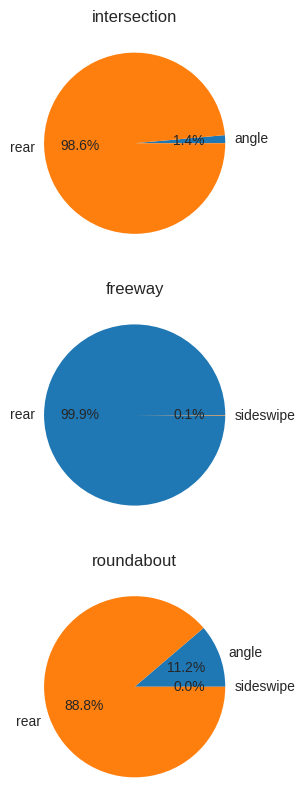

In [25]:
plt.figure(figsize=(30, 10))
plt.subplot(3, 1, 1)
pie_chart_plot(crash_type_dist, "intersection", "collision")
plt.subplot(3, 1, 2)
pie_chart_plot(crash_type_dist, "freeway", "collision")
plt.subplot(3, 1, 3)
pie_chart_plot(crash_type_dist, "roundabout", "collision")
plt.savefig(f"{export_stat_dir}/pie_chart.png")

In [26]:
len(neg_caused_collision)

86

#### Negligence reason

In [27]:
neg_reason_crash_dist = crash_distribution(neg_caused_collision, "neg_reason")
neg_reason_crash_dist

,location,neg_reason,count,exp_importance,collision_rate,importance_rate
0,freeway,Lead,20,0.009747,0.111732,5.445140e-05
1,freeway,RightFoll,8,0.000009,0.044693,4.806296e-08
2,intersection,Lead,25,0.000218,0.139665,1.219964e-06
3,roundabout,Lead,33,0.000093,0.184358,5.181824e-07


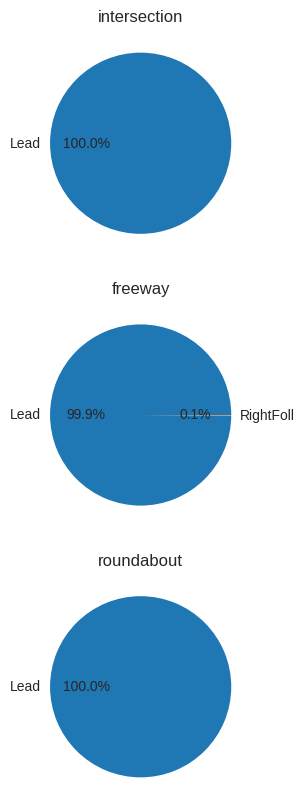

In [28]:
plt.figure(figsize=(30, 10))
plt.subplot(3, 1, 1)
pie_chart_plot(neg_reason_crash_dist, "intersection", "neg_reason")
plt.subplot(3, 1, 2)
pie_chart_plot(neg_reason_crash_dist, "freeway", "neg_reason")
plt.subplot(3, 1, 3)
pie_chart_plot(neg_reason_crash_dist, "roundabout", "neg_reason")
plt.savefig(f"{export_stat_dir}/neg_reason_pie_chart.png")

#### BV 22 Negligence Caused

In [29]:
is_veh_1_bv_22 = np.array(list(map(lambda x: x.startswith("BV_22"), neg_caused_collision["crash_veh_1"])))
is_veh_2_bv_22 = np.array(list(map(lambda x: x.startswith("BV_22"), neg_caused_collision["crash_veh_2"])))
has_bv_22 = is_veh_1_bv_22 | is_veh_2_bv_22
bv_22_neg_caused_collision = neg_caused_collision[has_bv_22]



bv_22_crash_type_dist = crash_distribution(bv_22_neg_caused_collision, "collision")
bv_22_crash_type_dist

,location,collision,count,exp_importance,collision_rate,importance_rate
0,freeway,rear,2,9.294556e-07,0.011173,5.192490e-09
1,intersection,rear,19,1.965371e-04,0.106145,1.097972e-06
2,roundabout,angle,2,1.274863e-06,0.011173,7.122141e-09
3,roundabout,rear,12,3.602615e-05,0.067039,2.012634e-07


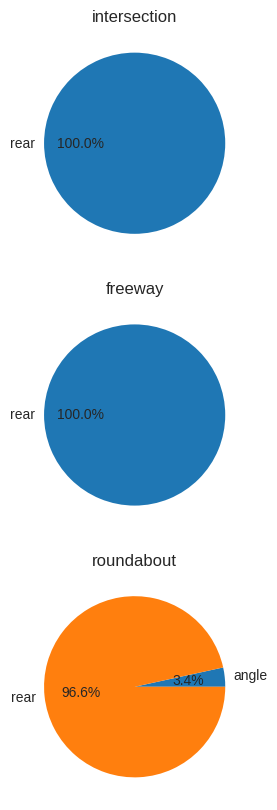

In [30]:
plt.figure(figsize=(30, 10))
plt.subplot(3, 1, 1)
pie_chart_plot(bv_22_crash_type_dist, "intersection", "collision")
plt.subplot(3, 1, 2)
pie_chart_plot(bv_22_crash_type_dist, "freeway", "collision")
plt.subplot(3, 1, 3)
pie_chart_plot(bv_22_crash_type_dist, "roundabout", "collision")
plt.savefig(f"{export_stat_dir}/bv_22_pie_chart.png")

##### EG happened collision intersection&angle

In [31]:
eg_collision = list(neg_caused_collision["lane_id"])
eg_collision_angle_df = neg_caused_collision[((neg_caused_collision["collision"] == "angle") | (neg_caused_collision["collision"] == "sideswipe")) & (neg_caused_collision["location"] == "freeway")]
# print(neg_caused_collision["relative_heading"])
# print(len(neg_caused_collision["relative_heading"]))

heading_float_list = [float(heading) for heading in eg_collision_angle_df["relative_heading"] if heading != 'None']
heading_float_list = np.array(heading_float_list)
print(len(heading_float_list))

8


In [32]:
eg_collision_angle_df = eg_collision_angle_df.sort_values(by="relative_heading")
eg_collision_angle_df["exp_cum"] = eg_collision_angle_df["exp_importance"].cumsum() / eg_collision_angle_df["exp_importance"].sum()
eg_collision_angle_df[eg_collision_angle_df["exp_cum"] < 28.08/(28.08+2.52)]

,name,end_time,crash_veh_1,crash_veh_2,importance,maneuver_challenge,neg_veh,neg_time_diff,neg_reason,neg_info,...,bv_22_route_length,lane_id,collision_type,location_type,relative_heading,distance,exp_importance,location,collision,exp_cum
75,cosim_test_localcomputer7_0_76,920.7,BV_21.56,CAV,6.202823,1,BV_21.56,0.6,RightFoll,highway_cutin,...,99.928186,EG_1_3_1_0,sideswipe,freeway_1,16.700078,-1.484357,6.268692e-07,freeway,sideswipe,0.072864
19,cosim_test_localcomputer7_0_20,926.6,BV_21.35,CAV,5.745248,11,BV_21.35,0.6,RightFoll,highway_cutin,...,226.721924,EG_1_3_1_0,sideswipe,freeway_1,17.481250,-1.789836,1.797842e-06,freeway,sideswipe,0.281836
46,cosim_test_localcomputer7_0_47,927.5,BV_21.47,CAV,6.111308,3,BV_21.47,0.6,RightFoll,highway_cutin,...,256.970624,EG_1_3_1_0,sideswipe,freeway_1,17.703806,-0.478649,7.739124e-07,freeway,sideswipe,0.371792
22,cosim_test_localcomputer7_0_23,928.6,BV_21.46,CAV,6.157066,2,BV_21.46,0.6,RightFoll,highway_cutin,...,203.026193,EG_1_3_1_0,sideswipe,freeway_1,17.745125,-0.240964,6.965212e-07,freeway,sideswipe,0.452752
108,cosim_test_localcomputer7_0_109,956.4,BV_21.42,CAV,6.111308,3,BV_21.42,0.6,RightFoll,highway_cutin,...,1314.941806,EG_1_3_1_0,sideswipe,freeway_1,18.452722,-2.662008,7.739124e-07,freeway,sideswipe,0.542707
158,cosim_test_localcomputer7_0_159,927.3,BV_21.40,CAV,5.836763,9,BV_21.40,0.6,RightFoll,highway_cutin,...,306.073637,EG_1_3_1_0,sideswipe,freeway_1,18.833594,-1.998567,1.456252e-06,freeway,sideswipe,0.711975
145,cosim_test_localcomputer7_0_146,941.1,BV_17.38,CAV,6.065551,4,BV_17.38,0.6,RightFoll,highway_cutin,...,422.075152,EG_1_3_1_0,sideswipe,freeway_1,19.191785,-1.054969,8.599027e-07,freeway,sideswipe,0.811925


0.0


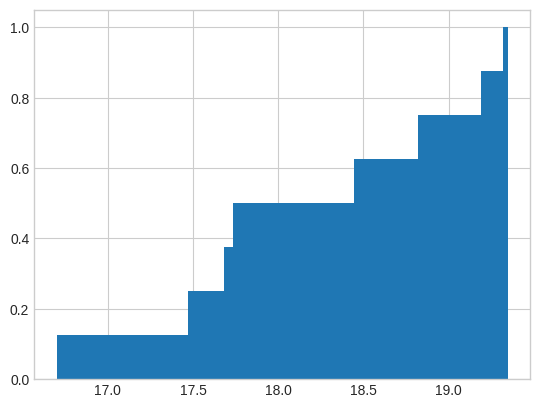

In [33]:
# # draw the histogram of the relative_heading of the collision in each location in neg_caused_collision
# grouped_neg_collision = neg_caused_collision["relative_heading"].groupby(neg_caused_collision["location"])
# for name, group_data in grouped_neg_collision:
#     plt.figure()
#     plt.hist(group_data, bins=50)
#     # plt.title(f"Collision Relative Heading Distribution in {name}")
# heading_flaot_list = np.clip(heading_flaot_list, 0, 30)
plt.figure()
plt.hist(heading_float_list, bins=100, density=True, cumulative=True)

print(np.sum(heading_float_list>20)/len(heading_float_list))

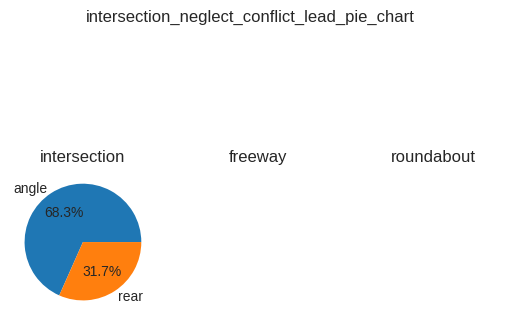

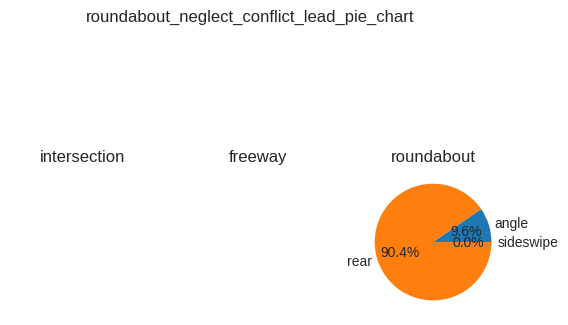

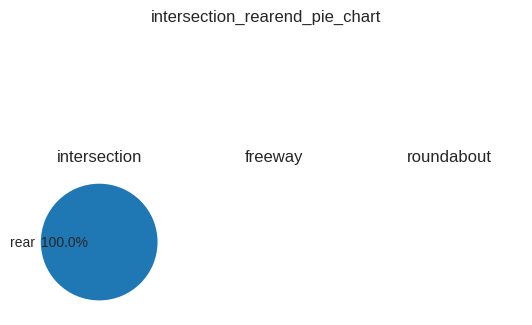

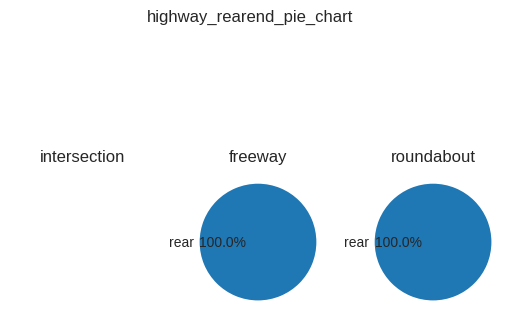

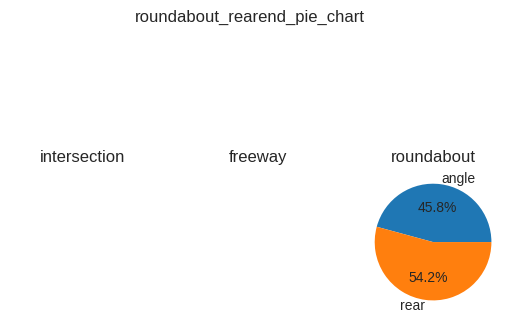

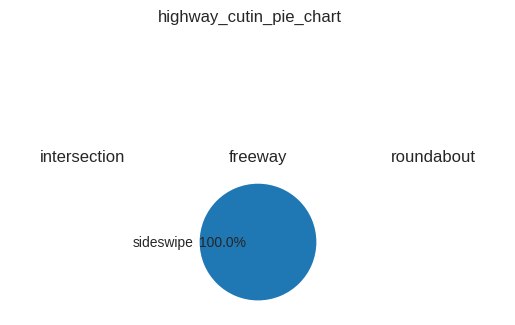

In [34]:
neg_uniq_infos = neg_caused_collision["neg_info"].unique()

neg_info_crash_dist = {}
for info in neg_uniq_infos:
    df = neg_caused_collision[neg_caused_collision["neg_info"] == info].copy()
    
    crash_type_dist = crash_distribution(df, "collision")
    neg_info_crash_dist[info] = crash_type_dist
    plt.figure()
    plt.subplot(1, 3, 1)
    pie_chart_plot(crash_type_dist, "intersection", "collision")
    plt.subplot(1, 3, 2)
    pie_chart_plot(crash_type_dist, "freeway", "collision")
    plt.subplot(1, 3, 3)
    pie_chart_plot(crash_type_dist, "roundabout", "collision")
    plt.suptitle(f"{info}_pie_chart")
    plt.savefig(f"{export_stat_dir}/{info}_pie_chart.png")

In [35]:
from IPython.display import display
for info, crash_dist in neg_info_crash_dist.items():
    print(info)
    display(crash_dist)

intersection_neglect_conflict_lead


,location,collision,count,exp_importance,collision_rate,importance_rate
0,intersection,angle,4,0.000003,0.022346,1.741877e-08
1,intersection,rear,1,0.000001,0.005587,8.067093e-09


roundabout_neglect_conflict_lead


,location,collision,count,exp_importance,collision_rate,importance_rate
0,roundabout,angle,3,8.408033e-06,0.016760,4.697225e-08
1,roundabout,rear,13,7.943867e-05,0.072626,4.437915e-07
2,roundabout,sideswipe,3,2.540168e-10,0.016760,1.419088e-12


intersection_rearend


,location,collision,count,exp_importance,collision_rate,importance_rate
0,intersection,rear,20,0.000214,0.111732,0.000001


highway_rearend


,location,collision,count,exp_importance,collision_rate,importance_rate
0,freeway,rear,20,9.746800e-03,0.111732,5.445140e-05
1,roundabout,rear,1,4.942177e-07,0.005587,2.760993e-09


roundabout_rearend


,location,collision,count,exp_importance,collision_rate,importance_rate
0,roundabout,angle,5,0.000002,0.027933,1.128729e-08
1,roundabout,rear,8,0.000002,0.044693,1.336897e-08


highway_cutin


,location,collision,count,exp_importance,collision_rate,importance_rate
0,freeway,sideswipe,8,0.000009,0.044693,4.806296e-08


In [36]:
! pip install gurobipy
col_names = ["ia", "ih", "ir", "is", "ra", "rr", "rs", "fr", "fs", "fa"]

row_names = [
    "intersection_cutin", 
    "intersection_neglect_conflict_lead", 
    "intersection_rearend", 
    "intersection_tfl",
    "intersection_headon",
    "roundabout_cutin",
    "roundabout_neglect_conflict_lead",
    "roundabout_rearend",
    "highway_cutin",
    "highway_rearend"
]

translate_col = {col: i for i, col in enumerate(col_names)}
translate_row = {row: i for i, row in enumerate(row_names)}

A = np.zeros((len(translate_row), len(translate_col))).astype(int)
for row_mark in neg_info_crash_dist.keys():
    df = neg_info_crash_dist[row_mark]
    important_values = df["importance_rate"]
    col_marks = np.array(list(map(lambda x: x[1][0][0]+x[1][1][0], df.iterrows())))
    for col_mark, v in zip(col_marks, important_values):
        if col_mark in translate_col:
            A[translate_row[row_mark], translate_col[col_mark]] = v * 1e9
A = A.T

In [37]:
A[:4, 5:] = 0
A[4:, :5] = 0
A[:7, 8:] = 0
A[7:, :8] = 0

In [38]:
A

array([[    0,    17,     0,     0,     0,     0,     0,     0,     0,
            0],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0],
       [    0,     8,  1194,     0,     0,     0,     0,     0,     0,
            0],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0],
       [    0,     0,     0,     0,     0,     0,    46,    11,     0,
            0],
       [    0,     0,     0,     0,     0,     0,   443,    13,     0,
            0],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
        54451],
       [    0,     0,     0,     0,     0,     0,     0,     0,    48,
            0],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]])

#### Calibration

In [39]:
import itertools
import numpy as np
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB

class StopExecution(Exception):
    def _render_traceback_(self):
        pass

# basic parameters
n = A.shape[1]
m = A.shape[0]
b = np.array([1839, 285, 1648, 808, 169, 53, 85, 1058, 428, 38])
all_miles = all_routes / mile_to_m
b = b / b.sum() * all_miles / num_experiments * 3e3

# Gurobi model
model = gp.Model()
model.reset()

# variable
x = model.addVars(range(n), lb=0.1)
t = model.addVars(range(m), lb=0)
upper = model.addVar(lb=1)
lower = model.addVar(lb=0)

# optimization goal
model.setObjective(sum(t[i] for i in range(m)) + 20 * upper + 200 * (1-lower), GRB.MINIMIZE)

# constraints
model.addConstrs(sum(x[j] * A[i, j] for j in range(n)) - b[i] <= t[i] for i in range(m))
model.addConstrs(sum(x[j] * A[i, j] for j in range(n)) - b[i] >= -t[i] for i in range(m))
model.addConstrs(x[i] <= upper for i in range(n))
model.addConstrs(x[i] >= lower for i in range(n))
model.update()

# solve the model
model.optimize()
if model.status != GRB.Status.OPTIMAL:
    print("***** Gurobi solve status:", model.status)
    print("***** This is a problem. Model does not have an optimal solution")
    raise StopExecution
print(" ")
print("***** Solution:")
# x_solved = np.array([x[i].X for i in range(n)]).reshape(-1, 1)
# t_solved = np.array([t[i].X for i in range(m)]).reshape(-1, 1)
x_solved = [x[i].X for i in range(n)]
t_solved = [t[i].X for i in range(m)]
x_mark_solved = list(zip(translate_row, x_solved))
t_mark_solved = list(zip(translate_col, t_solved))
print("x =",  *x_mark_solved, sep="\n")
print("t =",  *t_mark_solved, sep="\n")
print("x upper bound = ", upper.X)
print("x upper bound = ", lower.X)
print("b =", b)

Restricted license - for non-production use only - expires 2024-10-28
Discarded solution information
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i9-11900K @ 3.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 40 rows, 22 columns and 78 nonzeros
Model fingerprint: 0x6554fa64
Coefficient statistics:
  Matrix range     [1e+00, 5e+04]
  Objective range  [1e+00, 2e+02]
  Bounds range     [1e-01, 1e+00]
  RHS range        [6e+02, 3e+04]
Presolve removed 15 rows and 8 columns
Presolve time: 0.00s
Presolved: 25 rows, 14 columns, 56 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.0000000e+32   7.000000e+30   2.000000e+02      0s
      13    5.1838846e+04   0.000000e+00   0.000000e+00      0s

Solved in 13 iterations and 0.00 seconds (0.00 work units)
Optimal objective  5.183884572e+04
 
***** Solution:
x =


### Quick check

In [40]:
quick_check_exp = no_neg_realated_collision.groupby("lane_id").agg({
    "name": ["nunique", "first"],
    # "veh_1_route": set,
    # "veh_2_route": set,
    # "experiment": "first"
})
# quick_check_exp["veh_route"] = quick_check_exp[["veh_1_route", "veh_2_route"]].apply(lambda x: set(x[0]) | set(x[1]), axis=1)
quick_check_exp.sort_values(by=("name", "nunique"), ascending=False)

name                                
             nunique                           first
lane_id                                             
:NODE_22_3_0       5  cosim_test_localcomputer7_0_52
:NODE_22_2_0       1  cosim_test_localcomputer7_0_73

0.0019114747901373733 8.031175544585844e-17


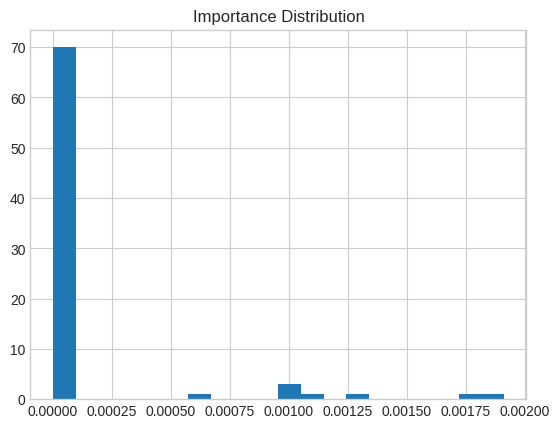

In [41]:
plt.hist(collide_importance_weight, bins=20)
plt.title("Importance Distribution")
plt.savefig(f'{export_stat_dir}/importance.png', dpi=300)
print(collide_importance_weight.max(), collide_importance_weight.min())

#### Export the checklist

In [42]:
# simple checklist
quick_check_list_path = f"{export_stat_dir}/quick_check_list.txt"
neg_caused_check_list_path = f"{export_stat_dir}/neg_caused_check_list.txt"
non_neg_check_list_path = f"{export_stat_dir}/non_neg_check_list.txt"

with open(quick_check_list_path, "w") as f:
    print(*set(quick_check_exp[("name", "first")].values), sep="\n", file=f)
with open(neg_caused_check_list_path, "w") as f:
    print(*set(neg_caused_collision["name"].values), sep="\n", file=f)
with open(non_neg_check_list_path, "w") as f:
    print(*set(no_neg_realated_collision["name"].values), sep="\n", file=f)

In [43]:
# ! pip install shapely

In [44]:
exp_stats_info

,name,end_time,crash_veh_1,crash_veh_2,importance,maneuver_challenge,neg_veh,neg_time_diff,neg_reason,neg_info,route_length,bv_22_route_length,lane_id,collision_type,location_type,relative_heading,distance
0,cosim_test_localcomputer7_0_1,1137.1,CAV,BV_12.11,6.252246,1,BV_12.11,3.1,Lead,intersection_neglect_conflict_lead,48035.531115,1032.919326,:NODE_17_1_0,angle,intersection,100.516761,3.280000
1,cosim_test_localcomputer7_0_2,1357.9,NaN,NaN,-0.228786,5,NaN,-1.0,NaN,NaN,78744.947529,5900.028687,NaN,NaN,NaN,NaN,-10.000000
2,cosim_test_localcomputer7_0_3,1058.2,CAV,BV_14.10,10.104945,9,BV_14.10,1.5,Lead,roundabout_neglect_conflict_lead,33690.383682,2299.468542,:nd_15_1_2_0_0,sideswipe,roundabout,11.273857,0.134092
3,cosim_test_localcomputer7_0_4,1241.6,NaN,NaN,-0.183029,4,NaN,-1.0,NaN,NaN,70380.516888,3906.857286,NaN,NaN,NaN,NaN,-10.000000
4,cosim_test_localcomputer7_0_5,1312.5,NaN,NaN,-0.091515,2,NaN,-1.0,NaN,NaN,78843.004866,4437.000672,NaN,NaN,NaN,NaN,-10.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174,cosim_test_localcomputer7_0_175,1055.5,CAV,BV_22.11,5.075364,4,BV_22.11,2.3,Lead,roundabout_neglect_conflict_lead,31522.119975,2197.085811,:nd_15_1_2_0_0,rear_end,roundabout,1.276050,1.608929
175,cosim_test_localcomputer7_0_176,1338.4,NaN,NaN,-0.366058,8,NaN,-1.0,NaN,NaN,81676.609764,3198.075558,NaN,NaN,NaN,NaN,-10.000000
176,cosim_test_localcomputer7_0_177,1254.5,NaN,NaN,-0.045757,1,NaN,-1.0,NaN,NaN,78548.403523,4054.331955,NaN,NaN,NaN,NaN,-10.000000
177,cosim_test_localcomputer7_0_178,951.9,CAV,BV_8.43,5.940308,13,BV_8.43,0.0,Lead,highway_rearend,10199.413425,22.342376,EG_1_3_1_0,rear_end,freeway_1,4.359039,-0.037987


### Generate videos in the check list

In [45]:
exp_stats_info["location"] = list(map(get_type_func, exp_stats_info["location_type"]))
exp_stats_info["collision"] = list(map(get_type_func, exp_stats_info["collision_type"]))

In [46]:
def get_location_collision_type(exp_id, exp_stats_info):
    mark = exp_stats_info["name"] == exp_id
    location_type = exp_stats_info[mark]["location"].values[0]
    collision_type = exp_stats_info[mark]["collision"].values[0]
    return location_type, collision_type

def export_videos(export_path, file_name, map_location="."):
    if not os.path.exists(export_path):
        os.system(f"mkdir -p {export_path}")
        os.system(f"chmod 755 {export_path}")
    with open(file_name) as f:
        for line in tqdm(f.readlines()): 
            exp_id = line.strip()
            path_name = os.path.join(experiment_record_repo, exp_id)
            if os.path.isdir(path_name):
                location_type, collision_type = get_location_collision_type(exp_id, exp_stats_info)
                if location_type == "None" or collision_type == "None":
                    visualizer(map_location, experiment_record_repo, exp_id, os.path.join(export_path, "None"))
                else:
                    visualizer(map_location, experiment_record_repo, exp_id, os.path.join(export_path, f"{location_type}/{collision_type}"))

  0%|          | 0/6 [00:00<?, ?it/s]/media/mtl/2TB/Safe-Test-TeraSim/SumoTrajVis/Net.py:260: ShapelyDeprecationWarning: The 'GeometryType()' method is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if self.shape.geometryType() != "Polygon":
 17%|█▋        | 1/6 [00:19<01:38, 19.63s/it]/media/mtl/2TB/Safe-Test-TeraSim/SumoTrajVis/Net.py:260: ShapelyDeprecationWarning: The 'GeometryType()' method is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if self.shape.geometryType() != "Polygon":
 33%|███▎      | 2/6 [00:38<01:15, 18.92s/it]/media/mtl/2TB/Safe-Test-TeraSim/SumoTrajVis/Net.py:260: ShapelyDeprecationWarning: The 'GeometryType()' method is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if self.shape.geometryType() != "Polygon":
 50%|█████     | 3/6 [00:56<00:56, 18.82s/it]/media/mtl/2TB/Safe-Test-TeraSim/SumoTrajVis/Net.py:260: ShapelyDe

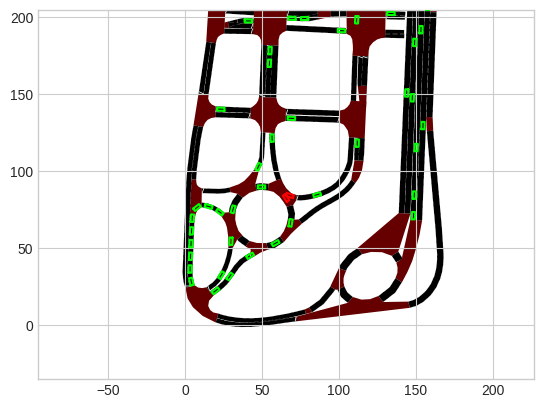

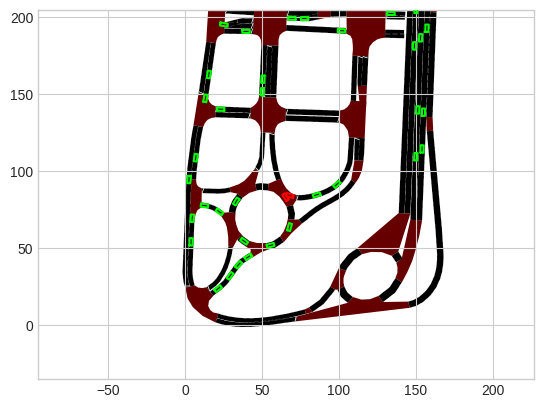

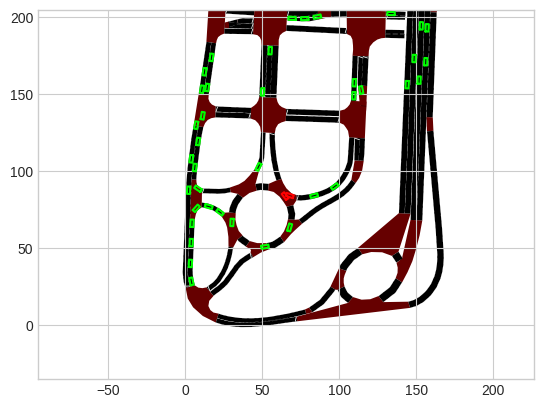

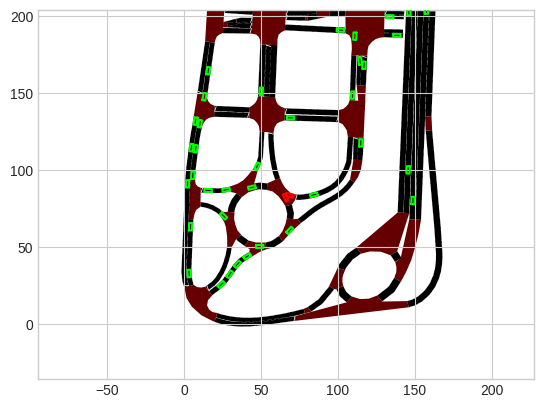

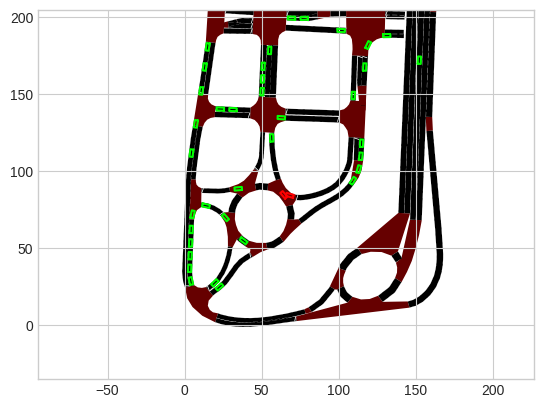

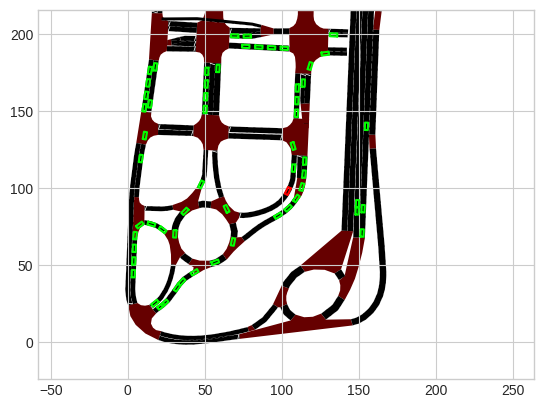

In [50]:
# 生成三个文件夹: simple(typical) non-negligence-caused negligence-caused 
export_path = f"{exp_repo}/{mode}/{user}/videos"
file_name = f"{export_stat_dir}/check_list.txt"

# quick check
# export_videos(f"{export_path}/quick_check", "check.txt")

export_videos(f"{export_path}/non_neg_check", non_neg_check_list_path)
# export_videos(f"{export_path}/neg_caused_check", neg_caused_check_list_path)

### See README-viz.md for visualization

In [48]:
exp_stats_info[(exp_stats_info["location"] == "roundabout") & (exp_stats_info["lane_id"] == ":NODE_21_0_0") & (exp_stats_info["neg_info"] == "roundabout_neglect_conflict_lead")]["name"].values

array([], dtype=object)

In [49]:
exp_stats_info[(exp_stats_info["location"] == "roundabout")]["lane_id"].unique()

array([':nd_15_1_2_0_0', ':NODE_7_0_0', 'EG_9_1_1_0', ':NODE_14_1_0',
       ':NODE_22_1_0', ':nd_15_1_3_0_0', ':NODE_22_3_0', ':NODE_22_2_0',
       'EG_16_45_1_0'], dtype=object)